# Figure 3

Figure 3 plots the following keywords for 51 NOAA active regions observed during the HMI-MDI overlap period:
* `USFLUXL`, the total unsigned flux (in Maxwells)
* `R_VALUE`, the R parameter (as detailed in Schrijver+2007), which is a measure of the flux near the polarity inversion line, in Maxwells
* `MEANGBL`, the mean value of the vertical field gradient in Gauss/Mm
* `CMASKL`, the number of pixels that contribute to the calculation of a keyword

In [1]:
import drms
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime as dt_obj
import matplotlib.pyplot as plt
from sunpy.net import Fido
from sunpy.net import attrs as a
from sunpy.io.special import srs
from itertools import chain
from scipy import stats
from dateutil.relativedelta import *
import math
pd.set_option('max_rows', 500) #print df as large as 500 rows

In [2]:
# define some constants
radsindeg = np.pi/180.
munaught  = 0.0000012566370614

The first step in querying for the SMARP and SHARP data is to establish a connection to JSOC. This can be done with the Client() class. (Register to download data from JSOC [here](http://jsoc.stanford.edu/ajax/register_email.html)).

In [3]:
email='your@email.address' # Put in a registered e-mail address
c = drms.Client(debug=True, verbose=True, email=email)

http://jsoc.stanford.edu/cgi-bin/ajax/checkAddress.sh?address=mbobra%2540stanford.edu&checkonly=1


### Find all the NOAA active regions that appear in both the SMARP and SHARP database

The overlap period begins when HMI takes regular observations, on May 1, 2010. The overlap period ends on the last day of the mdi.mtarp series, on October 28, 2010. 

MDI continued to take some observations until April 11, 2011 -- and even turned back on from March 6-14, 2012 -- but gaps in the MDI data became more frequent after October 28, 2010. Therefore the SMARP series ends on October 28, 2010.

In [4]:
t_start = '2010.05.01_00:00:00_TAI'
t_end = '2010.10.28_00:00:00_TAI'

In [5]:
def parse_tai_string(tstr,datetime=True):
    year   = int(tstr[:4])
    month  = int(tstr[5:7])
    day    = int(tstr[8:10])
    hour   = int(tstr[11:13])
    minute = int(tstr[14:16])
    if datetime: return dt_obj(year,month,day,hour,minute)
    else: return year,month,day,hour,minute

In [6]:
delta_days = parse_tai_string(t_end) - parse_tai_string(t_start)

In [7]:
print("There are",delta_days.days,"in the overlap period.")

There are 180 in the overlap period.


Construct the queries to identify all the active regions during the overlap period that have a NOAA active region number (`NOAA_ARS <> \'MISSING\'`). Sample the data only once every two hours. This reduces the query time but does not miss any active regions (there are no HARPs or TARPs that live for shorter than two hours).

In [8]:
hmi_query_string = 'hmi.sharp_cea_720s[]['+t_start+'/180d@2h][? (NOAA_ARS <> \'MISSING\') ?]'
khmi = c.query(hmi_query_string, key='NOAA_ARS,HARPNUM')

mdi_query_string = 'mdi.smarp_cea_96m[]['+t_start+'/180d@2h][? (NOAA_ARS <> \'MISSING\') ?]'
kmdi = c.query(mdi_query_string, key='NOAA_ARS,TARPNUM')

http://jsoc.stanford.edu/cgi-bin/ajax/jsoc_info?op=rs_list&ds=hmi.sharp_cea_720s%5B%5D%5B2010.05.01_00%3A00%3A00_TAI%2F180d%402h%5D%5B%3F+%28NOAA_ARS+%3C%3E+%27MISSING%27%29+%3F%5D&key=NOAA_ARS%2CHARPNUM
http://jsoc.stanford.edu/cgi-bin/ajax/jsoc_info?op=series_struct&ds=hmi.sharp_cea_720s
http://jsoc.stanford.edu/cgi-bin/ajax/jsoc_info?op=rs_list&ds=mdi.smarp_cea_96m%5B%5D%5B2010.05.01_00%3A00%3A00_TAI%2F180d%402h%5D%5B%3F+%28NOAA_ARS+%3C%3E+%27MISSING%27%29+%3F%5D&key=NOAA_ARS%2CTARPNUM
http://jsoc.stanford.edu/cgi-bin/ajax/jsoc_info?op=series_struct&ds=mdi.smarp_cea_96m


Drop all rows that have a missing NOAA active region number

In [9]:
khmi = khmi.drop(khmi.index[khmi['NOAA_ARS'] == 'MISSING']);
kmdi = kmdi.drop(kmdi.index[kmdi['NOAA_ARS'] == 'MISSING']);

Find all the NOAA active regions that appear in both HMI and MDI

In [10]:
keys = pd.merge(khmi, kmdi, on='NOAA_ARS')

In [11]:
keys = keys.drop_duplicates().reset_index(drop='True')

In [12]:
print("There are",len(keys),"NOAA active regions that appear in both the SHARP and SMARP database.")

There are 51 NOAA active regions that appear in both the SHARP and SMARP database.


Note that `HARPNUM` 155 and `TARPNUM` 13550 both encapsulate two NOAA active regions: NOAA AR 11093 and 11099. While NOAA uses continuum intensity image data to identify active regions, we use magnetic field data to identify active regions. Therefore we do not expect a 1:1 correspondence between NOAA AR number and TARP or HARP number. 

Now let's see how many active regions NOAA identified during the overlap period by querying the NOAA solar active region summary files using the SunPy Fido SRSClient.

In [13]:
results = Fido.search(a.Time("2010/5/1", "2010/10/28"), a.Instrument.soon)

In [14]:
results = Fido.fetch(results);

Files Downloaded:   0%|          | 0/181 [00:00<?, ?file/s]

In [15]:
noaa_numbers = []
for i in range (len(results)):
    srs_table = srs.read_srs(results[i])
    noaa_numbers.append(list(srs_table['Number']))

In [16]:
noaa_numbers_list_unique = list(set(list(chain.from_iterable(noaa_numbers))))

In [17]:
print("There are",len(noaa_numbers_list_unique),"NOAA active regions during the MDI-HMI overlap period.")

There are 57 NOAA active regions during the MDI-HMI overlap period.


Identify all the NOAA active regions that do not appear in both the SMARP and SHARP database during the overlap period:

In [18]:
# convert pandas series into list individual noaa ar numbers as strings
noaa_strings_sharp_smarp = list(chain.from_iterable([(keys['NOAA_ARS'][i].split(',')) for i in range(len(keys))]))

# convert list of individual noaa ar numbers from strings to ints
noaa_ints_sharp_smarp = [int(x) for x in noaa_strings_sharp_smarp]

# compare noaa ars in SRS catalog to noaa ars in sharp+smarp database
out = [x for x in noaa_numbers_list_unique if x not in noaa_ints_sharp_smarp]
print(out)

[11065, 11071, 11077, 11091, 11104, 11107]


There are 6 NOAA active regions that don't appear in both the SHARP and SMARP data. Let's look at these one by one. To do this, it is helpful to look at the metadata output from the queries above, the NOAA SRS data, [Solar Monitor](https://www.solarmonitor.org/), and the [HARP](http://jsoc.stanford.edu/data/hmi/HARPs_movies/definitive/) and [TARP](http://jsoc.stanford.edu/data/mdi/mdi-tarp/mdi-browse/) movies.
1. **AR 11065** appears in the SHARP data but is not labelled in the SMARP data. It is, however, clearly TARPNUM 13389 in the SMARP data.
2. **AR 11071** appears in the SHARP data but is not labelled in the SMARP data. It is, however, clearly TARPNUM 13414 in the SMARP data.
3. **AR 11077** appears in both the SHARP and SMARP data, but in the SHARP data it is coupled with AR 11073 in HARPNUM 45. In the SMARP data, it is 11077 on its own. We rejected this from our list of NOAA ARs during the overlap period because we want only regions that have a 1:1 correspondence between NOAA ARs and [HARP/TARP]NUMs.
4. **AR 11091** does not appear in either the SHARP or SMARP data. Based on the SRS reports, it looks like a very small region at the limb that barely rose above a Hydrogen-alpha plage region (basically really small with minimal magnetic signature).
5. **AR 11104** appears in the SHARP data but does not appear in the SMARP data. It has an extremely small magnetic signature that likely requires the high resolution of the HMI data to pass the detection threshold.
6. **AR 11107** appears in the SHARP data but is not labelled in the SMARP data. It is, however, clearly TARPNUM 13611 in the SMARP data.

While the NOAA active region identification scheme is useful for making comparisons during the MDI-HMI overlap period, it does not identify all the magnetic activity on the Sun. 

### Plot all of the spaceweather keyword values for these common active regions

Query all the spaceweather keyword metadata for the common NOAA active regions identified above. Select all records where:
1. The same `T_REC` appears in both the SMARP and SHARP data,
2. The HARP or TARP is within 70 degrees of central meridian, and
3. The data are of good quality (`(QUALITY<262144)` for SMARP and `(QUALITY<65536)` for SHARP).

Note that here we are querying the keyword-only series su_mbobra.sharp_loskeys_720s.

In [19]:
list_of_dataframes = []

for i in range(len(keys)):
    HARPNUM = str(keys['HARPNUM'][i])
    TARPNUM = str(keys['TARPNUM'][i])
    
    print('Gathering data for HARPNUM', HARPNUM, 'and TARPNUM', TARPNUM)
    print('Working on active region',i+1,'out of 51.')
    
    # query all records for this harpnum
    hmi_query_string = 'hmi.sharp_cea_720s['+HARPNUM+'][][? (QUALITY<65536) ?]'
    khmi = c.query(hmi_query_string, key='T_REC,INSTRUME,NOAA_ARS,CRVAL1,CRLN_OBS,TELESCOP,USFLUX,MEANGBZ,R_VALUE,USFLUXL,MEANGBL,RSUN_REF,RSUN_OBS,DSUN_OBS,CDELT1,SIZE')    
    
    # query all records for this tarpnum
    mdi_query_string = 'mdi.smarp_cea_96m['+TARPNUM+'][][? (QUALITY<262144) ?]'
    kmdi = c.query(mdi_query_string, key='T_REC,TARPNUM,NOAA_ARS,CRVAL1,CRLN_OBS,USFLUXL,MEANGBL,R_VALUE,TELESCOP,RSUN_REF,RSUN_OBS,DSUN_OBS,CDELT1,SIZE')
        
    # merge SHARP and SMARP dataframes and only keep records with common T_RECs
    df = pd.merge(khmi, kmdi, on='T_REC', suffixes=('_HMI', '_MDI'))
    
    # drop rows with nans
    df = pd.DataFrame.dropna(df).reset_index(drop=True)
    
    # calculate the stonyhurst latitude: CRVAL1 - CRLN_OBS
    # and add it as another column
    stonyhurst_latitude = pd.Series(np.absolute(df['CRVAL1_HMI'] - df['CRLN_OBS_HMI']), name='stonyhurst_latitude')
    df = df.assign(stonyhurst_latitude=stonyhurst_latitude.values)    
    
    # drop rows with a stonyhurst_latitude value greater than 70
    df = df[stonyhurst_latitude < 70].reset_index(drop=True)
    
    # concatenate with other active region metadata keys
    list_of_dataframes.append(df)
    
    print('--- Merged ---')

Gathering data for HARPNUM 1 and TARPNUM 13395
Working on active region 1 out of 51.
http://jsoc.stanford.edu/cgi-bin/ajax/jsoc_info?op=rs_list&ds=hmi.sharp_cea_720s%5B1%5D%5B%5D%5B%3F+%28QUALITY%3C65536%29+%3F%5D&key=T_REC%2CINSTRUME%2CNOAA_ARS%2CCRVAL1%2CCRLN_OBS%2CTELESCOP%2CUSFLUX%2CMEANGBZ%2CR_VALUE%2CUSFLUXL%2CMEANGBL%2CRSUN_REF%2CRSUN_OBS%2CDSUN_OBS%2CCDELT1%2CSIZE
http://jsoc.stanford.edu/cgi-bin/ajax/jsoc_info?op=rs_list&ds=mdi.smarp_cea_96m%5B13395%5D%5B%5D%5B%3F+%28QUALITY%3C262144%29+%3F%5D&key=T_REC%2CTARPNUM%2CNOAA_ARS%2CCRVAL1%2CCRLN_OBS%2CUSFLUXL%2CMEANGBL%2CR_VALUE%2CTELESCOP%2CRSUN_REF%2CRSUN_OBS%2CDSUN_OBS%2CCDELT1%2CSIZE
--- Merged ---
Gathering data for HARPNUM 2 and TARPNUM 13394
Working on active region 2 out of 51.
http://jsoc.stanford.edu/cgi-bin/ajax/jsoc_info?op=rs_list&ds=hmi.sharp_cea_720s%5B2%5D%5B%5D%5B%3F+%28QUALITY%3C65536%29+%3F%5D&key=T_REC%2CINSTRUME%2CNOAA_ARS%2CCRVAL1%2CCRLN_OBS%2CTELESCOP%2CUSFLUX%2CMEANGBZ%2CR_VALUE%2CUSFLUXL%2CMEANGBL%2CRSUN_REF

### Plot distribution of space-weather parameters

In [20]:
df2 = pd.concat(list_of_dataframes).reset_index()

In [21]:
### Convert MEANGBL from Gauss/pixel to Gauss/Mm
cdelt1_arcsec_hmi = np.arctan((df2['RSUN_REF_HMI']*df2['CDELT1_HMI']*radsindeg)/(df2['DSUN_OBS_HMI']))*(1/radsindeg)*(3600.)
factor_hmi = (1/cdelt1_arcsec_hmi)*(df2['RSUN_OBS_HMI']/df2['RSUN_REF_HMI'])*(1000000)
df2['MEANGBL_HMI_units'] = df2['MEANGBL_HMI']*factor_hmi
df2['MEANGBZ_units'] = df2['MEANGBZ']*factor_hmi

cdelt1_arcsec_mdi = np.arctan((df2['RSUN_REF_MDI']*df2['CDELT1_MDI']*radsindeg)/(df2['DSUN_OBS_MDI']))*(1/radsindeg)*(3600.)
factor_mdi = (1/cdelt1_arcsec_mdi)*(df2['RSUN_OBS_MDI']/df2['RSUN_REF_MDI'])*(1000000)
df2['MEANGBL_MDI_units'] = df2['MEANGBL_MDI']*factor_mdi

In [22]:
# Create a column full of NaNs to for the HMI vector values of R_VALUE,
# since R_VALUE is only calculated on the line-of-sight data

df2['CRVAL1_HMI'][:] = np.nan

In [23]:
df3 = {
    "log R\n \n": df2['R_VALUE_MDI'].append(df2['R_VALUE_HMI']).append(df2['CRVAL1_HMI']), 
    "Mean Gradient of the\nVertical Field (Gauss Mm$\mathregular{^{-1}}$)": df2['MEANGBL_MDI_units'].append(df2['MEANGBL_HMI_units']).append(df2['MEANGBZ_units']),
    "Total Unsigned\nFlux (Maxwells)\n ": df2['USFLUXL_MDI'].append(df2['USFLUXL_HMI']).append(df2['USFLUX']),
    "Data Product": df2['TELESCOP_MDI'].append(df2['INSTRUME']).append(df2['TELESCOP_HMI'])
}

In [24]:
df4 = pd.concat(df3, axis = 1)

In [25]:
df4 = df4.replace(['SOHO'], ['SMARP']);
df4 = df4.replace(['HMI_SIDE1'], ['SHARP line-of-sight']);
df4 = df4.replace(['SDO/HMI'], ['SHARP vector']);

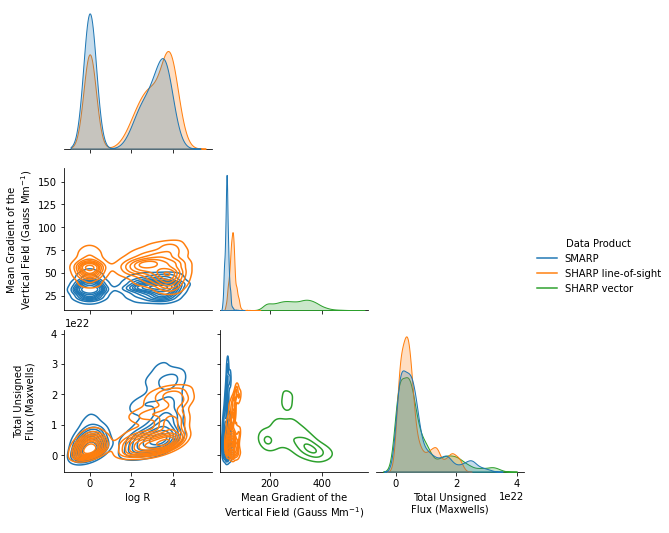

In [26]:
sns.pairplot(df4, kind='kde', hue='Data Product', corner=True)
plt.savefig('Figure3.pdf', dpi=300, bbox_inches='tight')

In [27]:
print('Data for this plot include',len(df4), 'unique observations.')
print('This plot shows three spaceweather keyword values per observation, or',len(df4)*3,'keyword values.')

Data for this plot include 12861 unique observations.
This plot shows three spaceweather keyword values per observation, or 38583 keyword values.


### Calculate correlation between variables

In [28]:
# Between the SMARP and SHARP LOS data
print(stats.spearmanr(df2['USFLUXL_MDI'], df2['USFLUXL_HMI']))
print(stats.spearmanr(df2['MEANGBL_MDI_units'], df2['MEANGBL_HMI_units']))
print(stats.spearmanr(df2['R_VALUE_MDI'], df2['R_VALUE_HMI']))

SpearmanrResult(correlation=0.9406958304511538, pvalue=0.0)
SpearmanrResult(correlation=0.7896433688047313, pvalue=0.0)
SpearmanrResult(correlation=0.8775618734265077, pvalue=0.0)


In [29]:
# Between the SMARP and SHARP Vector data
print(stats.spearmanr(df2['USFLUXL_MDI'], df2['USFLUX']))
print(stats.spearmanr(df2['MEANGBL_MDI_units'], df2['MEANGBZ_units']))

SpearmanrResult(correlation=0.7971849742357607, pvalue=0.0)
SpearmanrResult(correlation=0.36488262845960245, pvalue=3.797517611043668e-135)
